In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [35]:
from pathlib import Path

from cycler import cycler

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


from matplotlib import rcParams

import numpy as np
import pandas as pd


import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import geopandas as gpd

import intro_plots as ip

paper_path = Path('../paper/figures/')

slide_path = Path('../slides/figures/intro/')
proposal_path = Path('../draft/figures/intro/')
#rcParams['font.family'] = 'Segoe Print'

In [36]:
ny_all = pd.read_csv("nydata")

ny = ny_all[ny_all['NAME'].isin(ip.cdict.keys())].copy()

ny['DATES'] = pd.to_datetime(ny['DATE'])

In [37]:
nyjfk = ny[ny['NAME'].str.contains('JFK')].fillna(0)[['DATES', 'PRCPI']]

In [38]:
nyjfk['PRCPI2'] = nyjfk['PRCPI']*10

<AxesSubplot:>

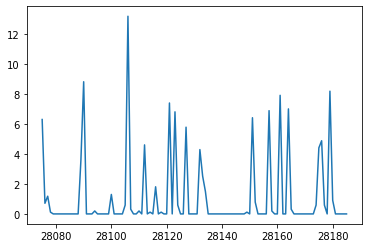

In [39]:
nyjfk['PRCPI2'].plot()

In [101]:
dfs = nyjfk[(nyjfk['DATES']>'2021-02-04') & (nyjfk['DATES']<'2021-02-15')]
dfs

,DATES,PRCPI,PRCPI2,PRCPI3
28110,2021-02-05,0.019685,0.19685,0.059055
28111,2021-02-06,0.000000,0.00000,0.000000
28112,2021-02-07,0.460629,4.60629,1.842516
28113,2021-02-08,0.000000,0.00000,0.000000
28114,2021-02-09,0.011811,0.11811,0.047244
28115,2021-02-10,0.000000,0.00000,-0.000000
28116,2021-02-11,0.181102,1.81102,0.000000
28117,2021-02-12,0.000000,0.00000,0.000000
28118,2021-02-13,0.011811,0.11811,0.011811
28119,2021-02-14,0.000000,0.00000,-0.000000


In [102]:
dfs['L1'] = dfs['PRCPI'].apply(lambda x: f"{x:1.4f}") 
dfs['L2'] = dfs['PRCPI2'].apply(lambda x: f"{x:1.4f}") 
dfs

<ipython-input-102-e3e35708b6b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['L1'] = dfs['PRCPI'].apply(lambda x: f"{x:1.4f}")
<ipython-input-102-e3e35708b6b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs['L2'] = dfs['PRCPI2'].apply(lambda x: f"{x:1.4f}")


,DATES,PRCPI,PRCPI2,PRCPI3,L1,L2
28110,2021-02-05,0.019685,0.19685,0.059055,0.0197,0.1969
28111,2021-02-06,0.000000,0.00000,0.000000,0.0000,0.0000
28112,2021-02-07,0.460629,4.60629,1.842516,0.4606,4.6063
28113,2021-02-08,0.000000,0.00000,0.000000,0.0000,0.0000
28114,2021-02-09,0.011811,0.11811,0.047244,0.0118,0.1181
28115,2021-02-10,0.000000,0.00000,-0.000000,0.0000,0.0000
28116,2021-02-11,0.181102,1.81102,0.000000,0.1811,1.8110
28117,2021-02-12,0.000000,0.00000,0.000000,0.0000,0.0000
28118,2021-02-13,0.011811,0.11811,0.011811,0.0118,0.1181
28119,2021-02-14,0.000000,0.00000,-0.000000,0.0000,0.0000


In [136]:
nyjfk['PRCPI3'] = nyjfk['PRCPI'] * np.random.randint(-5,6, len(nyjfk))

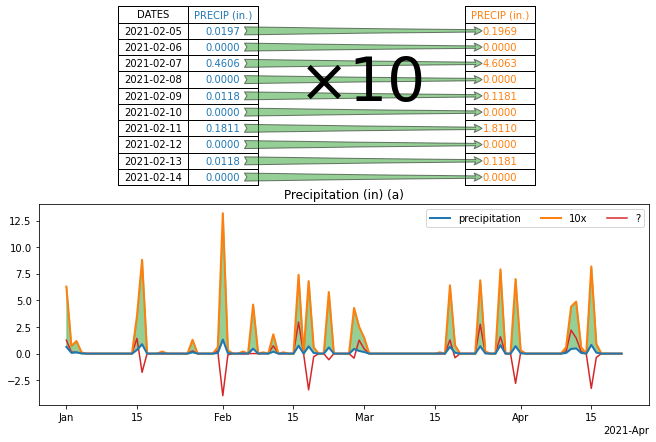

In [137]:
gridspec_kw={'height_ratios':[1,3]}
fig, axd = plt.subplot_mosaic([['tab1','tab2'], ['time','time']], 
                              constrained_layout=True, gridspec_kw=gridspec_kw,
                              figsize=(9,6))
#gridspec_kw={'width_ratios':}

ocolor = 'tab:blue'
scolor = 'tab:orange'
gcolor = 'tab:green'
table_1 = ip.plot_table(axd['tab1'], dfs[['DATES', 'L1']], ['k', ocolor], textcolor=None)
table_2 = ip.plot_table(axd['tab2'], dfs[['L2']], [scolor], textcolor=None)
fig.canvas.draw()
table_1[(0,1)].get_text().set_text('PRECIP (in.)')
table_2[(0,0)].get_text().set_text('PRECIP (in.)')

axd['time'].plot('DATES', 'PRCPI', data=nyjfk, color=ocolor, zorder=10, lw=2, label='precipitation')
axd['time'].plot('DATES', 'PRCPI2', data=nyjfk, color=scolor, zorder=9, lw=2, label='10x')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
axd['time'].set_title("Precipitation (in) (a)")

galpha = .5

axd['time'].fill_between('DATES','PRCPI', 'PRCPI2', data=nyjfk, color=gcolor, alpha=galpha, zorder=5)
axd['time'].plot('DATES', 'PRCPI3', data=nyjfk, color='tab:red', zorder=8, label='?')
for i in range(1,len(dfs)+1):
    x1, y1 = ip.source_cell(table_1[i,1], ocolor, xr=1.1)
    x2, y2 = ip.source_cell(table_2[i,0], scolor, xr=.05)
    
    arrow = mpatches.ConnectionPatch(xyA=(x1, y1), coordsA=axd['tab1'].transData,
                                     xyB=(x2, y2), coordsB=axd['tab2'].transData,   
                                     arrowstyle="fancy", mutation_scale=20, 
                                     facecolor=gcolor, edgecolor='black', alpha=galpha)
    fig.add_artist(arrow)
    



axd['time'].legend(ncol=3)
fig.text(.55, .82, r"$\times 10$", ha='center', va='center', fontsize=60)
fig.savefig(proposal_path/"equivariant.png", dpi = 200)

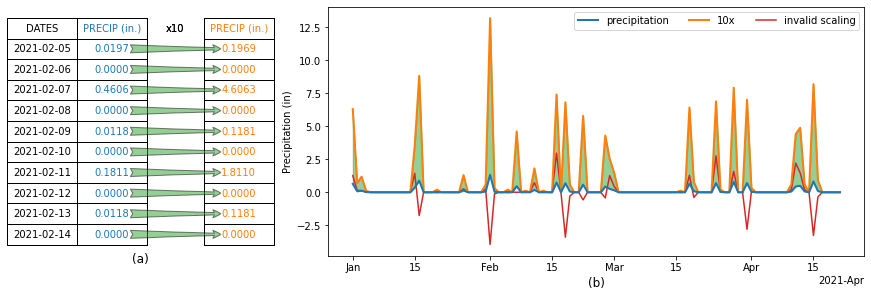

In [160]:
gridspec_kw={'height_ratios':[1,3]}
fig, axd = plt.subplot_mosaic([['table','time']],
                              constrained_layout=True, 
                              gridspec_kw={'width_ratios':[1,2]},
                              figsize=(12,4))
#gridspec_kw={'width_ratios':}

ocolor = 'tab:blue'
scolor = 'tab:orange'
gcolor = 'tab:green'
table = ip.plot_table(axd['table'], dfs[['DATES', 'L1', 'PRCPI', 'L2']], ['k', ocolor, 'white', scolor], 
                        textcolor=None)
#table_2 = ip.plot_table(axd['tab2'], dfs[['L2']], [scolor], textcolor=None)
fig.canvas.draw()
table[(0,1)].get_text().set_text('PRECIP (in.)')
table[(0,3)].get_text().set_text('PRECIP (in.)')

axd['time'].plot('DATES', 'PRCPI', data=nyjfk, color=ocolor, zorder=10, lw=2, label='precipitation')
axd['time'].plot('DATES', 'PRCPI2', data=nyjfk, color=scolor, zorder=9, lw=2, label='10x')
axd['time'].xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.MonthLocator()))
galpha = .5

axd['time'].fill_between('DATES','PRCPI', 'PRCPI2', data=nyjfk, color=gcolor, alpha=galpha, zorder=5)
axd['time'].plot('DATES', 'PRCPI3', data=nyjfk, color='tab:red', zorder=8, label='invalid scaling')
table[0,2].visible_edges = 'vertical'
table[0,2].get_text().set_text("x10")
table[0,2].get_text().set_color('black')
for i in range(1,len(dfs)+1):
    table[i,2].visible_edges = 'vertical'
    x1, y1 = ip.source_cell(table[i,1], ocolor, xr=.6)
    x2, y2 = ip.source_cell(table[i,3], scolor, xr=.5)
    
    arrow = mpatches.ConnectionPatch(xyA=(x1, y1), coordsA=axd['table'].transData,
                                     xyB=(x2, y2), coordsB=axd['table'].transData,   
                                     arrowstyle="fancy", mutation_scale=20, 
                                     facecolor=gcolor, edgecolor='black', alpha=galpha)
    fig.add_artist(arrow)

axd['time'].legend(ncol=3)

axd['time'].set_ylabel("Precipitation (in)")
axd['time'].xaxis.set_label_position('bottom')
axd['time'].set_xlabel("(b)", fontsize='large')
axd['table'].set_title("(a)", y=-.05, fontsize='large')
fig.savefig(proposal_path/"equivariant.png", dpi = 200)